# Lab5. SVD and weighted SVD on MovieLens.

In [1]:
import os

import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

### 1) MovieLens Dataset.

#### a) This data set consists of:
   - 100,000 ratings (1-5) from 943 users on 1682 movies.
   - Each user has rated at least 20 movies.

#### b) It is preferable to begin with this dataset, because its size is applicable for the research purposes and was preprocessed by the authors.

#### c) Data loading.

In [2]:
NUM_RATINGS = int(1e5)
DATA_SHAPE = (943, 1682)
DATA_DIR = os.path.join(".", "data", "movielens", "ml-100k")

In [3]:
ratings_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", header=None, names=("User ID", "Item ID", "Rating", "Timestamp"))
ratings_df.head(10)

,User ID,Item ID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [4]:
ratings_df.groupby("User ID")["Item ID"].count().describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: Item ID, dtype: float64

In [5]:
values = ratings_df.values
values[:, 0:2] -= 1
ratings_df.head()

,User ID,Item ID,Rating,Timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


#### d) The difference between table df and rating matrix M is that table df contains raw data of records and has shape (100k x #features), while matrix M will be sparse rating matrix of shape (#users x #items) with rating or miss in each cell.

### 2: Data preprocessing.

#### a) Obtain a sparse rating matrix M.

In [6]:
M = csr_matrix((ratings_df["Rating"], (ratings_df["User ID"], ratings_df["Item ID"])), dtype=np.float64, shape=DATA_SHAPE)
M

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 100000 stored elements in Compressed Sparse Row format>

#### b) In a sparse matrix, missing data is typically represented by a special value, such as zero or NaN (not a number).

#### c) Perform train-test split.

In [7]:
train_fraction = 0.9
train_size = int(train_fraction * NUM_RATINGS)

indices = np.random.permutation(range(NUM_RATINGS))
indices_train = indices[0:train_size]
indices_test = indices[train_size:NUM_RATINGS]

M_train = csr_matrix((ratings_df["Rating"][indices_train], (ratings_df["User ID"][indices_train], ratings_df["Item ID"][indices_train])),
                     dtype=float, shape=DATA_SHAPE)
M_test = csr_matrix((ratings_df["Rating"][indices_test], (ratings_df["User ID"][indices_test], ratings_df["Item ID"][indices_test])),
                    dtype=float, shape=DATA_SHAPE)

In [8]:
print(M_train.__repr__())
print(M_test.__repr__())

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 90000 stored elements in Compressed Sparse Row format>
<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in Compressed Sparse Row format>


#### d) Compute global mean rating.

In [9]:
global_mean_rating = np.sum(M_train) / np.sum(M_train > 0.5)
print(f"Global mean rating: {global_mean_rating:.3f}")

Global mean rating: 3.532


#### e) Compute test MSE if prediction is made using global mean rating.

In [10]:
mask_train = M_train > 0.5
mask_test = M_test > 0.5

diff = np.array(M_test[mask_test] - global_mean_rating)
mse = np.mean(diff ** 2)
rmse = mse ** (1 / 2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 1.2749145427160493
RMSE: 1.1291211373081496


### 3: Recommending using SVD.

#### a) Compute the 20 First factors of the SVD of the centered training data.

In [11]:
M_train_centered = M_train.copy()
M_train_centered[mask_train] = M_train[mask_train] - global_mean_rating
M_test_centered = M_test.copy()
M_test_centered[mask_test] = M_test[mask_test] - global_mean_rating

In [12]:
num_factors = 20

U, D, Vt = svds(M_train_centered, k=num_factors)

U = U[:, ::-1]
D = D[::-1]
Vt = Vt[::-1, :]

In [13]:
print(U.shape, D.shape, Vt.shape)

(943, 20) (20,) (20, 1682)


#### b) Predict missing test values using different number of components and plot it.

In [14]:
def svd_mse(_U, _D, _Vt, k):
    _M_pred = _U[:, 0:k] @ np.diag(_D[0:k]) @ _Vt[0:k, :]
    # _M_pred = _U[:, 0:k] @ _Vt[0:k, :]

    _M_err = M_test_centered - mask_test.multiply(_M_pred)

    _mse = np.sum(_M_err.power(2)) / np.sum(mask_test)

    return _mse

In [15]:
errors = list()

for i in range(1, num_factors + 1):
    errors.append(svd_mse(U, D, Vt, i))

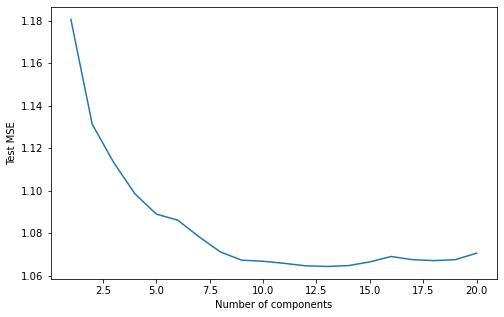

In [16]:
plt.figure(figsize=(8, 5))
plt.xlabel("Number of components")
plt.ylabel("Test MSE")
plt.plot(range(1, num_factors + 1), errors)
plt.show()

### 4: Recommending using the weighted SVD.

#### a) Alternating least square.

In [17]:
def mse(_U, _D, _Vt):
    # _M_pred = _U @ np.diag(_D) @ _Vt
    _M_pred = _U @ _Vt

    _M_err = M_test_centered - mask_test.multiply(_M_pred)

    _mse = np.sum(_M_err.power(2)) / np.sum(mask_test)

    return _mse

In [18]:
_lambda = 2
n_iter = 15

U_star = U.copy()
Vt_star = Vt.copy()

errors = list()

for iteration in range(n_iter):
    print(f"Iteration: {iteration}")

    for i in range(len(U)):
        Di = np.diag(mask_train[i].toarray().flatten())
        A = np.linalg.pinv(Vt_star @ Di @ Vt_star.T + _lambda * np.identity(num_factors))
        Ri = M_train_centered[i].T
        B = Vt_star @ Di @ Ri
        U_star[i] = (A @ B).flatten()

    for j in range(Vt.shape[1]):
        Dj = np.diag(mask_train[:, j].toarray().flatten())
        Rj = M_train_centered[:, j]
        A = np.linalg.pinv(U_star.T @ Dj @ U_star + _lambda * np.identity(num_factors))
        B = U_star.T @ Dj @ Rj
        Vt_star[:, j] = (A @ B).flatten()

    error = mse(U_star, D, Vt_star)
    errors.append(error)
    print(f"Test MSE: {error}")

Iteration: 0
Test MSE: 1.2604869644458179
Iteration: 1
Test MSE: 1.1771393828643522
Iteration: 2
Test MSE: 1.151237252732463
Iteration: 3
Test MSE: 1.1390950875202375
Iteration: 4
Test MSE: 1.132163101363564
Iteration: 5
Test MSE: 1.1281786322726564
Iteration: 6
Test MSE: 1.1260635150819123
Iteration: 7
Test MSE: 1.1251029387920692
Iteration: 8
Test MSE: 1.1248817985968973
Iteration: 9
Test MSE: 1.1251789884029957
Iteration: 10
Test MSE: 1.1258644962111592
Iteration: 11
Test MSE: 1.1268476593785155
Iteration: 12
Test MSE: 1.1280515904371644
Iteration: 13
Test MSE: 1.129401053664905
Iteration: 14
Test MSE: 1.1308230432571462


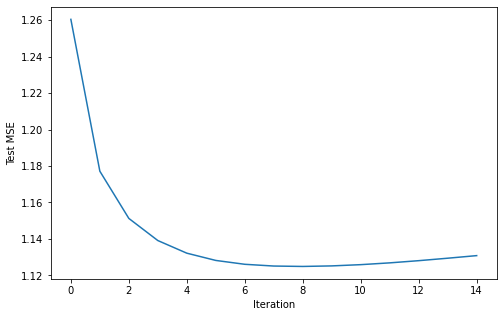

In [19]:
plt.figure(figsize=(8, 5))
plt.xlabel("Iteration")
plt.ylabel("Test MSE")
plt.plot(range(n_iter), errors)
plt.show()

In [26]:
def funk_svd(M, num_factors = 20 , num_epochs=50, learning_rate=0.01, reg=0.01):
    n_users, n_items = M.shape
    U = np.random.randn(n_users, num_factors) / num_factors
    V = np.random.randn(n_items, num_factors) / num_factors

    def predict_all():
        return U.dot(V.T)

    train_mse_list = []
    test_mse_list = []

    # Mask for known ratings
    mask = M != 0

    for epoch in range(num_epochs):
        train_mse = 0.0

        # Loop through each known rating
        for i, j in zip(*np.where(mask.toarray())):
            pred = predict_all()[i, j]
            error = M[i, j] - pred
            train_mse += error**2

            # Update U and V based on error
            U[i, :] += learning_rate * (error * V[j, :] - reg * U[i, :])
            V[j, :] += learning_rate * (error * U[i, :] - reg * V[j, :])

        # Calculate train and test mse
        train_mse = np.sqrt(train_mse / np.sum(mask))
        test_mse = np.sqrt(np.sum((M_test - predict_all())**2) / np.sum(mask_test))

        train_mse_list.append(train_mse)
        test_mse_list.append(test_mse)

        print("Epoch: {}, Train MSE: {:.4f}, Test MSE: {:.4f}".format(epoch, train_mse, test_mse))

    return U, V, train_mse_list, test_mse_list


In [27]:
funk_svd(M)

LinAlgError: Last 2 dimensions of the array must be square

In [55]:
def funk_svd(M, num_factors=10, num_epochs=10, learning_rate=0.1, reg=0.01):
    n_users, n_items = M.shape
    U = np.random.randn(n_users, num_factors) / num_factors
    V = np.random.randn(n_items, num_factors) / num_factors

    def predict_all():
        return U.dot(V.T)

    train_mse_list = []
    test_mse_list = []

    # Mask for known ratings
    mask = M != 0
    mask_test = M_test != 0

    for epoch in range(num_epochs):
        train_mse = 0.0

        # Loop through each known rating
        for i, j in zip(*np.where(mask.toarray())):
            pred = predict_all()[i, j]
            error = M[i, j] - pred
            train_mse += error ** 2

            # Update U and V based on error
            U[i, :] += learning_rate * (error * V[j, :] - reg * U[i, :])
            V[j, :] += learning_rate * (error * U[i, :] - reg * V[j, :])

        # Calculate train and test mse
        train_mse = np.sqrt(train_mse / np.sum(mask))
        test_mse = np.sqrt(np.sum((M_test[mask_test.toarray()] - predict_all()[mask_test.toarray()])**2) / np.sum(mask_test))


        train_mse_list.append(train_mse)
        test_mse_list.append(test_mse)

        print(f"Iteration: {epoch}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

    return U, V, train_mse_list, test_mse_list


In [57]:
funk_svd(M)



<ipython-input-55-64a72bfe28a1>:23: RuntimeWarning: overflow encountered in double_scalars
  train_mse += error ** 2
<ipython-input-55-64a72bfe28a1>:27: RuntimeWarning: overflow encountered in multiply
  V[j, :] += learning_rate * (error * U[i, :] - reg * V[j, :])
<ipython-input-55-64a72bfe28a1>:26: RuntimeWarning: invalid value encountered in add
  U[i, :] += learning_rate * (error * V[j, :] - reg * U[i, :])
<ipython-input-55-64a72bfe28a1>:26: RuntimeWarning: overflow encountered in multiply
  U[i, :] += learning_rate * (error * V[j, :] - reg * U[i, :])


LinAlgError: Last 2 dimensions of the array must be square

In [65]:
import numpy as np
import random

# Define the hyperparameters
num_factors = 10
learning_rate = 0.01
num_epochs = 10
reg_param = 0.1

# Load the ratings matrix R
R = M

# Initialize the user and item latent factors
num_users, num_items = R.shape
U = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
V = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

# Perform stochastic gradient descent
for epoch in range(num_epochs):
    # Shuffle the set of known ratings
    ratings = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]
    random.shuffle(ratings)
    
    # Update the latent factors for each known rating
    for i, j, r in ratings:
        # Compute the predicted rating
        r_hat = np.dot(U[i, :], V[j, :])
        
        # Compute the error term
        e = r - r_hat
        
        # Update the user and item latent factors
        for k in range(num_factors):
            U[i, k] += learning_rate * (e * V[j, k] - reg_param * U[i, k])
            V[j, k] += learning_rate * (e * U[i, k] - reg_param * V[j, k])
    
    # Compute the loss function
    loss = 0.5 * np.sum((R - U.dot(V.T)).multiply(R - U.dot(V.T)).power(2)) + 0.5 * reg_param * (np.sum(np.power(U.data, 2)) + np.sum(np.power(V.data, 2)))
    print('Epoch {}: loss = {}'.format(epoch+1, loss))


AttributeError: 'matrix' object has no attribute 'multiply'

In [70]:
import numpy as np
import random
from scipy.sparse import csr_matrix

# Define the hyperparameters
num_factors = 10
learning_rate = 0.01
num_epochs = 10
reg_param = 0.1

# Load the ratings matrix R
R = csr_matrix(M)

# Initialize the user and item latent factors
num_users, num_items = R.shape
U = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
V = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

# Perform stochastic gradient descent
for epoch in range(num_epochs):
    # Shuffle the set of known ratings
    users, items = R.nonzero()
    indices = list(zip(users, items))
    random.shuffle(indices)
    
    # Update the latent factors for each known rating
    for i, j in indices:
        # Compute the predicted rating
        r_hat = np.dot(U[i, :], V[j, :].T)
        
        # Compute the error term
        e = R[i, j] - r_hat
        
        # Update the user and item latent factors
        for k in range(num_factors):
            U[i, k] += learning_rate * (e * V[j, k] - reg_param * U[i, k])
            V[j, k] += learning_rate * (e * U[i, k] - reg_param * V[j, k])
    
    # Compute the loss function
    loss = 0.5 * np.sum(R.power(2) - 2 * R.multiply(U.dot(V.T)) + (U.dot(V.T)).power(2)) + 0.5 * reg_param * (np.sum(U.power(2)) + np.sum(V.power(2)))
    print('Epoch {}: loss = {}'.format(epoch+1, loss))


AttributeError: 'numpy.ndarray' object has no attribute 'power'

In [74]:
import numpy as np
import random
from scipy.sparse import csr_matrix

# Define the hyperparameters
num_factors = 10
learning_rate = 0.01
num_epochs = 10
reg_param = 0.1

# Load the ratings matrix R
R = csr_matrix(M)

# Initialize the user and item latent factors
num_users, num_items = R.shape
U = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
V = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

# Perform stochastic gradient descent
for epoch in range(num_epochs):
    # Shuffle the set of known ratings
    users, items = R.nonzero()
    indices = list(zip(users, items))
    random.shuffle(indices)
    
    # Update the latent factors for each known rating
    for i, j in indices:
        # Compute the predicted rating
        r_hat = np.dot(U[i, :], V[j, :].T)
        
        # Compute the error term
        e = R[i, j] - r_hat
        
        # Update the user and item latent factors
        for k in range(num_factors):
            U[i, k] += learning_rate * (e * V[j, k] - reg_param * U[i, k])
            V[j, k] += learning_rate * (e * U[i, k] - reg_param * V[j, k])
    
    # Compute the loss function
    loss = 0.5 * np.sum((R.multiply(R) - 2 * R.multiply(csr_matrix(U).dot(csr_matrix(V).T)) + csr_matrix(U).dot(csr_matrix(V).T).multiply(csr_matrix(U).dot(csr_matrix(V).T))) + 0.5 * reg_param * (np.sum(np.power(U, 2)) + np.sum(np.power(V, 2)))
    print('Epoch {}: loss = {}'.format(epoch+1, loss))


SyntaxError: invalid syntax (<ipython-input-74-f2454d9f4718>, line 41)

### Better reccomendation using Surprise package 

In [29]:
ratings_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", header=None, names=("User ID", "Item ID", "Rating", "Timestamp"))
df = ratings_df

In [33]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split

# Load data into surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User ID', 'Item ID', 'Rating']], reader)

# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD algorithm
algo = SVD(n_factors=20, reg_all=0.1)
algo.fit(trainset)

# Evaluate algorithm
results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
print("Mean RMSE: {:.4f}".format(results['test_rmse'].mean()))

# Predict ratings for a specific user and item
uid = 1  # user ID
iid = 1  # item ID
pred = algo.predict(uid, iid, verbose=False)
print("Predicted rating for user {} and item {}: {:.2f}".format(uid, iid, pred.est))


Mean RMSE: 0.9416
Predicted rating for user 1 and item 1: 3.94


In [62]:
type(M)

scipy.sparse.csr.csr_matrix

In [63]:
print(U.shape, V.shape)

(943, 10) (1682, 10)
